# En pratique, on cherche un modèle à la fois sensible et spécifique .

Un faux positif se produit lorsqu'une transaction légitime est signalée comme frauduleuse

Un faux négatif survient lorsqu'une fraude réelle n'est pas détectée par le système

In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))  # permet d’accéder au dossier parent
from src.utils.imports import *
from src.utils.config import CREDITCARD_PATH

c:\Users\kadas\Desktop\Fraude\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Toutes les librairies principales importées avec succès (Data | ML | MLOps | API | Orchestration).


In [2]:
df = pd.read_csv(CREDITCARD_PATH)
print(f" Fichier chargé depuis : {CREDITCARD_PATH}")

 Fichier chargé depuis : C:\Users\kadas\Desktop\Fraude\fraudflow\data\creditcard.csv


In [3]:
df=df[["V14","V18","V7","V4","V11","V12","V10","V16","V3","V17","V9","V2","Class", "Amount","Time"]]

In [4]:
# Features et cible
X = df.drop(columns=["Class", "Amount"])
y = df["Class"]

In [5]:
#  Séparation Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=90
)

In [6]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [7]:
# 3. Entraînement du modèle
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=90
)

rf.fit(X_train_rf, y_train)

,n_estimators,400
,criterion,'gini'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


| Objectif                                     | Paramètre                           | Ce qu’il fait                                                      | Recommandation               |
| -------------------------------------------- | ----------------------------------- | ------------------------------------------------------------------ | ---------------------------- |
| 🔧 **Limiter la profondeur**                 | `max_depth`                         | stoppe la croissance des arbres trop complexes                     | `10 ≤ max_depth ≤ 20`        |
| 🍃 **Éviter feuilles trop petites**          | `min_samples_leaf`                  | chaque feuille contient au moins X échantillons                    | `2 ≤ min_samples_leaf ≤ 5`   |
| 🌿 **Limiter les splits trop fins**          | `min_samples_split`                 | un nœud doit contenir au moins X échantillons avant d’être splitté | `3 ≤ min_samples_split ≤ 10` |
| 🎲 **Réduire la corrélation entre arbres**   | `max_features`                      | limite le nb de variables testées à chaque split                   | `"sqrt"` ou `"log2"`         |
| 🌪️ **Utiliser l’échantillonnage bootstrap** | `bootstrap=True`                    | chaque arbre voit un sous-échantillon des données                  | toujours `True` (par défaut) |
| ⚖️ **Équilibrer les classes**                | `class_weight='balanced_subsample'` | pondère selon le déséquilibre                                      | déjà fait 👍                 |
| 🌳 **Réduire le nb d’arbres**                | `n_estimators`                      | moins d’arbres → moins de variance (mais plus de biais)            | entre 200 et 400 suffisent   |


le RandomForestClassifier n’a pas de early_stopping car c’est un ensemble d’arbres indépendants (chaque arbre est entraîné jusqu’à sa fin, sans itérations successives).

In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='average_precision')
print(f"AUPRC CV moyen : {scores.mean():.4f} ± {scores.std():.4f}")

AUPRC CV moyen : 0.8427 ± 0.0304


En validation croisée 5 folds, j’obtiens un AUPRC moyen de 0.839 avec un écart-type de 0.03, ce qui montre que le modèle est stable et généralise bien sur différentes partitions.

In [ ]:
# 4️. Prédictions et probabilités
y_pred_rf = rf.predict(X_test_rf)   # seuil par défaut = 0.5
y_proba_rf = rf.predict_proba(X_test_rf)[:, 1]  # probas de la classe 1 (fraude)

In [ ]:
#  Choix du seuil personnalisé 
seuil = 0.1
y_pred_custom = (y_proba_rf >= seuil).astype(int)    

In [43]:
# 5️. Évaluation - AUPRC + Rapport

auprc_rf = average_precision_score(y_test, y_proba_rf)
print(f"\nAUPRC (Precision-Recall) : {auprc_rf:.4f}")

#  Rapport avec seuil par défaut (0.5)
print("\n=== Classification Report (seuil par défaut = 0.5) ===")
print(classification_report(y_test, y_pred_rf, digits=4))

#  Rapport avec ton seuil personnalisé (0.1)
print(f"\n=== Classification Report (seuil personnalisé = {seuil}) ===")
print(classification_report(y_test, y_pred_custom, digits=4))



AUPRC (Precision-Recall) : 0.7986

=== Classification Report (seuil par défaut = 0.5) ===
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56864
           1     0.8987    0.7245    0.8023        98

    accuracy                         0.9994     56962
   macro avg     0.9491    0.8622    0.9010     56962
weighted avg     0.9994    0.9994    0.9994     56962


=== Classification Report (seuil personnalisé = 0.1) ===
              precision    recall  f1-score   support

           0     0.9997    0.9989    0.9993     56864
           1     0.5603    0.8061    0.6611        98

    accuracy                         0.9986     56962
   macro avg     0.7800    0.9025    0.8302     56962
weighted avg     0.9989    0.9986    0.9987     56962



Avec seuil = 0.5 (défaut) :

Recall des fraudes : 72.45% → vous manquez ~28% des fraudes

Avec seuil = 0.1 :

Recall des fraudes : 80.61% → vous manquez seulement ~19% des fraudes

Avec le seuil à 0.1, je  détecte 8% de fraudes supplémentaires (gain de 8 fraudes sur vos 98 cas), ce qui est significatif.

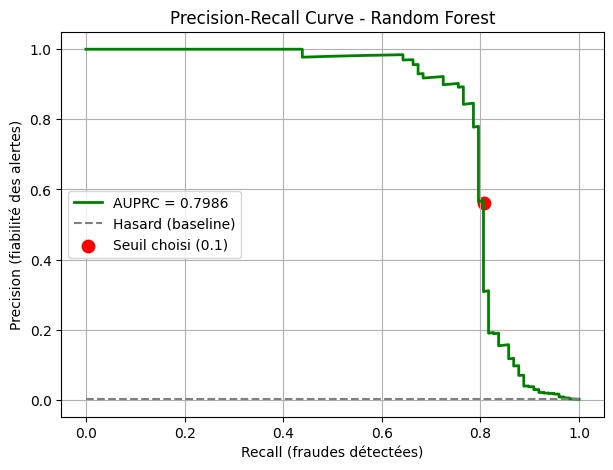

In [53]:
# 6️ Courbe Precision-Recall + seuil choisi

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='green', lw=2, label=f"AUPRC = {auprc_rf:.4f}")
plt.plot([0, 1], [np.mean(y_test)]*2, linestyle='--', color='gray', label="Hasard (baseline)")

#  ajout du point correspondant à ton seuil choisi (0.1)
# on cherche le point le plus proche du seuil

idx_seuil = np.argmin(np.abs(thresholds - 0.1))
plt.scatter(recall[idx_seuil], precision[idx_seuil],
            color='red', s=80, label='Seuil choisi (0.1)')

plt.title("Precision-Recall Curve - Random Forest")
plt.xlabel("Recall (fraudes détectées)")
plt.ylabel("Precision (fiabilité des alertes)")
plt.legend()
plt.grid(True)
plt.show()


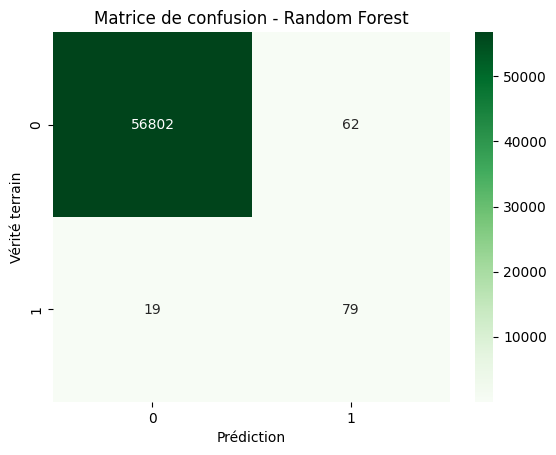


AUPRC Train: 0.9855 | AUPRC Test: 0.7986


In [57]:
# 7️. Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

# 8️. AUPRC Train vs Test (pour vérifier sur-apprentissage)
# ==========================================================
y_train_proba_rf = rf.predict_proba(X_train_rf)[:, 1]
auprc_train_rf = average_precision_score(y_train, y_train_proba_rf)

print(f"\nAUPRC Train: {auprc_train_rf:.4f} | AUPRC Test: {auprc_rf:.4f}")

In [59]:
# Extraction des éléments
VN = cm_rf[0, 0]  # Vrais négatifs
FP = cm_rf[0, 1]  # Faux positifs
FN = cm_rf[1, 0]  # Faux négatifs
VP = cm_rf[1, 1]  # Vrais positifs

# Calcul des métriques de base
specificite = VN / (VN + FP)             # TNR
sensibilite = VP / (VP + FN)             # Recall
precision = VP / (VP + FP)               # Precision

print(f"Spécificité (TNR) : {specificite:.4f}")
print(f"Sensibilité (Recall) : {sensibilite:.4f}")
print(f"Précision (PPV) : {precision:.4f}")

Spécificité (TNR) : 0.9989
Sensibilité (Recall) : 0.8061
Précision (PPV) : 0.5603


Le modèle est à la fois très spécifique (0.999) — donc fiable sur les transactions normales — et raisonnablement sensible (0.81), ce qui en fait un bon équilibre entre sécurité et efficacité opérationnelle.

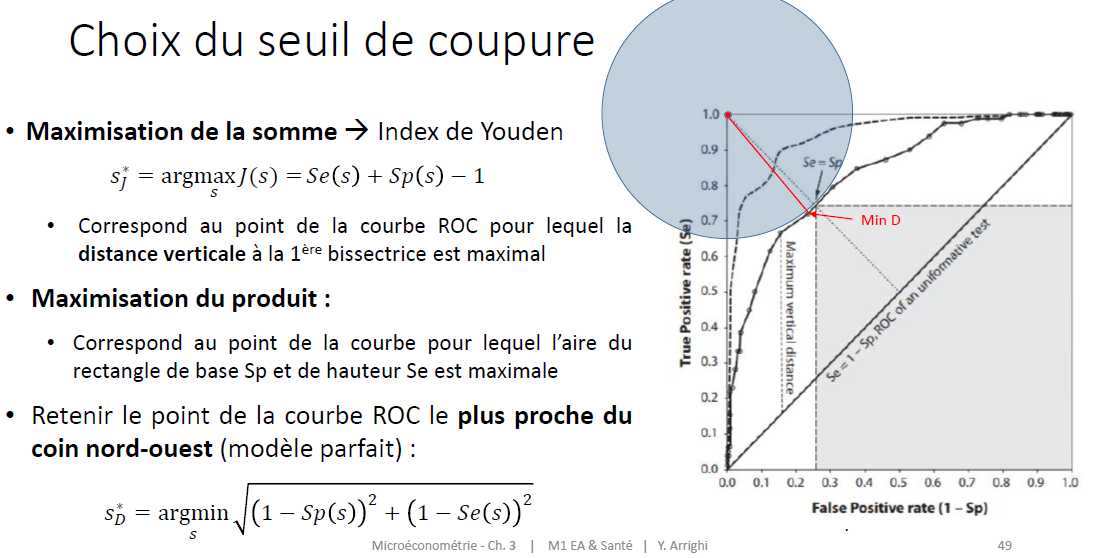

In [36]:
#  Méthode F1-max  (équilibre précision / rappel)

f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx_f1 = np.argmax(f1)
seuil_f1 = thresholds[best_idx_f1]


#  Méthode Top-k% (seuil métier : top 1% ou 0.5%)

k = 0.01  # 1% des transactions les plus suspectes
seuil_topk = np.quantile(y_proba_rf, 1 - k)


#  Méthode "Index de Youden" adaptée à PR-curve 
#  max(Recall + Precision - 1)

youden_pr = recall + precision - 1
best_idx_youden = np.argmax(youden_pr)
seuil_youden = thresholds[best_idx_youden]


In [37]:
# Résumé des seuils trouvés

print(f"\nSeuil F1-max     : {seuil_f1:.4f}")
print(f"Seuil Top-1%     : {seuil_topk:.4f}")
print(f"Seuil Youden-PR  : {seuil_youden:.4f}")


Seuil F1-max     : 0.4115
Seuil Top-1%     : 0.0255
Seuil Youden-PR  : 0.4115
